# **Emotion Recognition using Facial Expressions**

## Step 1: Importing Required Libraries

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

## Step 2: Data Preprocessing

In [2]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [7]:
#Text to numerical labeling
emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [8]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [11]:
#calculate the side length of the images
math.sqrt(len(df.pixels[0].split(' ')))

48.0

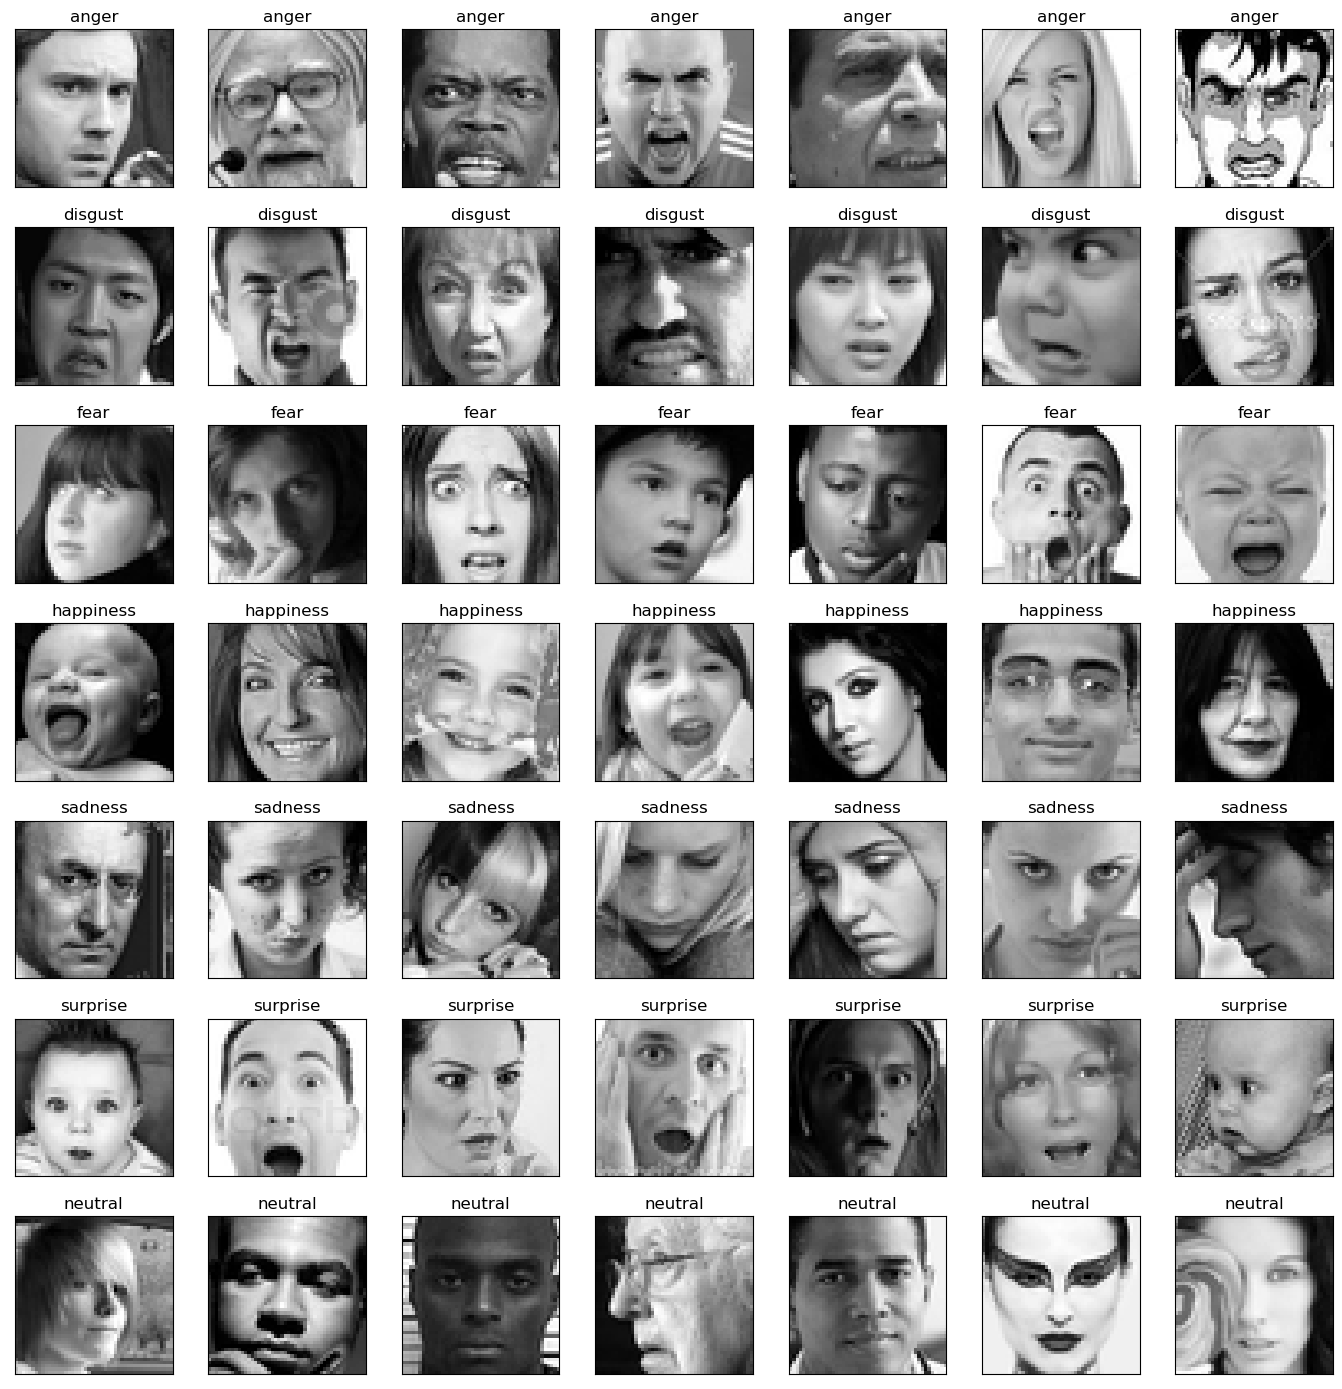

In [13]:
#Viewing the images
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_labels[label])
        pyplot.tight_layout()

Explanations of each lines:

* fig = pyplot.figure(1, (14, 14)): This line creates a new figure with figure number 1 and dimensions of 14 inches by 14 inches.
* k = 0: This initializes a counter variable k to zero.
* for label in sorted(df.emotion.unique()):: This loops over the unique emotion labels in the emotion column of the df DataFrame, sorted in ascending order.
* for j in range(7):: This nested loop creates 7 columns of subplots for each emotion category.
* px = df[df.emotion==label].pixels.iloc[k]: This line selects the k-th image from the pixels column of the df DataFrame that belongs to the current label emotion category, and stores it in a variable px.
* px = np.array(px.split(' ')).reshape(48, 48).astype('float32'): This line converts the string of pixel values into a NumPy array, reshapes it into a 48x48 array, and converts it to a float32 data type.
* k += 1: This increments the k counter variable by 1.
* ax = pyplot.subplot(7, 7, k): This creates a new subplot with a 7x7 grid layout, and selects the k-th subplot as the current one to plot the current image.
* ax.imshow(px, cmap = 'gray'): This displays the image data stored in px on the current subplot, using a grayscale color map.
* ax.set_xticks([]): This removes the x-axis tick labels from the current subplot.
* ax.set_yticks([]): This removes the y-axis tick labels from the current subplot.
* ax.set_title(emotion_label_to_text[label]): This sets the title of the current subplot to the corresponding emotion label, as specified in a dictionary emotion_label_to_text.
* pyplot.tight_layout(): This adjusts the layout of the subplots to prevent overlapping.

### Next step is to make the data ready for neural networks

We know that the data df contains pixel values stored as strings.

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

* img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32')): This line uses the Pandas apply() function to apply a lambda function to each element in the pixels column of the df DataFrame. The lambda function splits the string of pixel values into an array of strings using the space character as a delimiter, converts the resulting array into a 48x48 NumPy array of float32 data type, and returns the array. The resulting output is a Pandas Series of NumPy arrays.
* img_array = np.stack(img_array, axis = 0): This line uses the NumPy stack() function to stack the arrays in the Pandas Series along the 0-th axis, creating a 3D NumPy array of shape (n_samples, 48, 48), where n_samples is the number of samples in the original DataFrame. This creates a NumPy array of image data that can be used as input for machine learning models.

In [15]:
#Viewing the shape of image array created
img_array.shape

(35887, 48, 48)

In [16]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


Each grayscale image in img_array is converted to an RGB image using OpenCV's cvtColor() function with the COLOR_GRAY2RGB flag. This results in a list of RGB images stored in img_features.

Note: It is not always necessary to convert a 3D NumPy array of grayscale images into a 4D NumPy array of RGB images for face emotion recognition using TensorFlow. However, some convolutional neural network (CNN) architectures may require input images to have three color channels (i.e., RGB format) instead of one (i.e., grayscale format). In such cases, converting grayscale images to RGB format is necessary.
In particular, some CNN architectures are designed to work with RGB images and use convolutional filters that expect input tensors with three color channels. If grayscale images are used as input instead, the filters may not be able to learn relevant features from the input images, leading to poor performance.

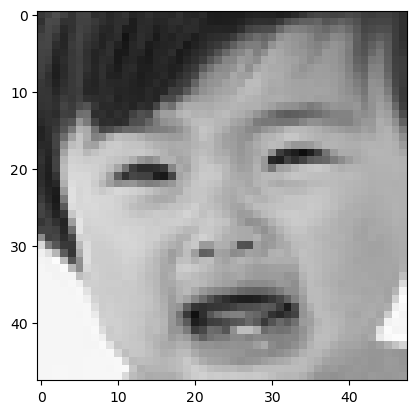

In [19]:
#Showing an image from those
pyplot.imshow(img_features[400].astype(np.uint8));

Thw shown image is Black & White and you may confused why it is bw even when we converted to 4D with RGB channels. This is because, the image is actually black and white: If the original grayscale image was predominantly black and white, then the resulting RGB image created by duplicating the grayscale values across all three color channels would also be mostly black and white.

In [20]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In this code block, the LabelEncoder class from Scikit-learn is used to convert the categorical labels in the df.emotion column to numerical labels, which are then converted to one-hot encoded binary vectors using the np_utils.to_categorical() function from Keras.
The resulting img_labels array is a 2D NumPy array of shape (n_samples, n_classes), where n_samples is the number of images in the dataset and n_classes is the number of unique labels in the dataset. Each row in the array corresponds to a single image and contains a binary vector representing the label of the image.
The img_labels array is used as the target variable in a supervised learning model, where the goal is to predict the label of a new image given its pixel values.

In [21]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


This code block creates a dictionary le_name_mapping that maps each unique label in the df.emotion column to a numerical label using the LabelEncoder class from Scikit-learn.

The zip() function is used to pair each unique label with its corresponding numerical label, which is obtained using the le.transform() method of the LabelEncoder object le. The resulting pairs are then passed to the dict() function to create a dictionary that maps each unique label to its numerical label.

The resulting le_name_mapping dictionary can be useful for interpreting the output of a machine learning model that uses the numerical labels as its predicted outputs. By mapping the predicted numerical label back to its corresponding categorical label using le_name_mapping, we can interpret the output of the model in terms of the original categories.

For example, if the model predicts a numerical label of 3, we can use le.inverse_transform([3]) to obtain the corresponding categorical label, such as 'happy'. If we also have le_name_mapping, we can simply look up the label using le_name_mapping[3] to obtain 'happy'.

## Step 3: Training the model

In [22]:
#Train and Test split of data
X_train, X_valid, y_train, y_valid = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [23]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Next step is to normalize the results since neural networks are very sensitive to unnormalized data.

In [24]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [25]:
# Loading VGG19 convolutional neural network (CNN) from Keras
vgg19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [26]:
# Making all layers of VGG19 model non-trainable
for layer in vgg19.layers:
    layer.trainable = False

When a model is marked as non-trainable, the weights of its layers are fixed and remain unchanged during training. In other words, the model will not adjust its weights based on the current training data.

Setting the layers of the pre-trained VGG19 model to be non-trainable has the effect of using the pre-learned features of the model for the new problem at hand, without updating the model's weights based on the new data. This is called transfer learning, and it allows us to use a pre-trained model for a new task, which may have fewer training examples or a different distribution of data than the original task.

Using transfer learning with a pre-trained model like VGG19 is generally considered a good practice in deep learning, especially when the amount of data available for the new problem is limited.

By using pre-trained weights, we can take advantage of the model's ability to learn meaningful features from images, without having to train a new model from scratch. This saves time and computational resources, and can often lead to better results than training a new model with limited data.

However, the performance of the pre-trained model on the new task depends on the similarity of the new data to the data on which the model was originally trained. If the new data is very different, the pre-trained weights may not be useful, and it may be necessary to fine-tune the model's weights on the new data. In some cases, it may also be necessary to modify the architecture of the pre-trained model to better suit the new task.

In the context of facial emotion recognition using the VGG19 model, we are taking advantage of the pre-learned features of the VGG19 model for image classification, and adapting it for our specific task of recognizing facial emotions. By keeping the pre-trained weights fixed, we can use the power of transfer learning to improve the performance of our model on our specific task.

In [27]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [28]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

The function first takes the output of the second-to-last layer of the pre-trained model, which contains high-level features learned from the input images, and passes it through a global average pooling layer. This layer takes the average of each feature map in the input and reduces the spatial dimensions of the output to 1x1, while retaining the channel dimension.

The output of the global average pooling layer is then passed through a fully connected Dense layer with a softmax activation function, which outputs a probability distribution over the possible classes of facial emotions.

The resulting model has all layers of the pre-trained model frozen, and only the newly added layers are trainable. This is because the pre-trained weights are already optimized for a specific task (image classification on ImageNet), and we want to preserve these weights while only adjusting the new layers for the task of facial emotion recognition.

In [29]:
head = build_model(vgg19, num_classes)
model = Model(inputs = vgg19.input, outputs = head)

In [30]:
#'early stopping' for avoiding overfitting training data and `ReduceLROnPlateau` for learning rate

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [31]:
#Generating more training data
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [32]:
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

This code sets the hyperparameters for training the facial emotion recognition model.

batch_size specifies the number of samples to use in each iteration of training. In this case, 32 samples will be used in each iteration.

epochs specifies the number of times to iterate over the entire training dataset. In this case, the model will be trained for 25 epochs.

optims is a list of optimizers to use during training. In this case, it contains a single optimizer: Adam. Adam is a popular optimizer that adapts the learning rate during training based on the gradient history.

Finally, the code compiles the model with the specified loss function (categorical_crossentropy), optimizer (optims[0]), and metric to evaluate during training (accuracy).

In [33]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1009/1009 [==============================] - 41s 33ms/step - loss: 1.8395 - accuracy: 0.2335 - val_loss: 1.7508 - val_accuracy: 0.2945 - lr: 1.0000e-04
Epoch 2/25
1009/1009 [==============================] - 33s 33ms/step - loss: 1.7431 - accuracy: 0.2867 - val_loss: 1.7096 - val_accuracy: 0.3188 - lr: 1.0000e-04
Epoch 3/25
1009/1009 [==============================] - 32s 32ms/step - loss: 1.7174 - accuracy: 0.3064 - val_loss: 1.6885 - val_accuracy: 0.3196 - lr: 1.0000e-04
Epoch 4/25
1009/1009 [==============================] - 33s 32ms/step - loss: 1.7033 - accuracy: 0.3131 - val_loss: 1.6746 - val_accuracy: 0.3268 - lr: 1.0000e-04
Epoch 5/25
1009/1009 [==============================] - 34s 33ms/step - loss: 1.6953 - accuracy: 0.3192 - val_loss: 1.6653 - val_accuracy: 0.3310 - lr: 1.0000e-04
Epoch 6/25
1009/1009 [==============================] - 33s 32ms/step - loss: 1.6893 - accuracy: 0.3216 - val_loss: 1.6566 - val_accuracy: 0.3349 - lr: 1.0000e-04
Epoch 7/25
1009/1009 [

In [35]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

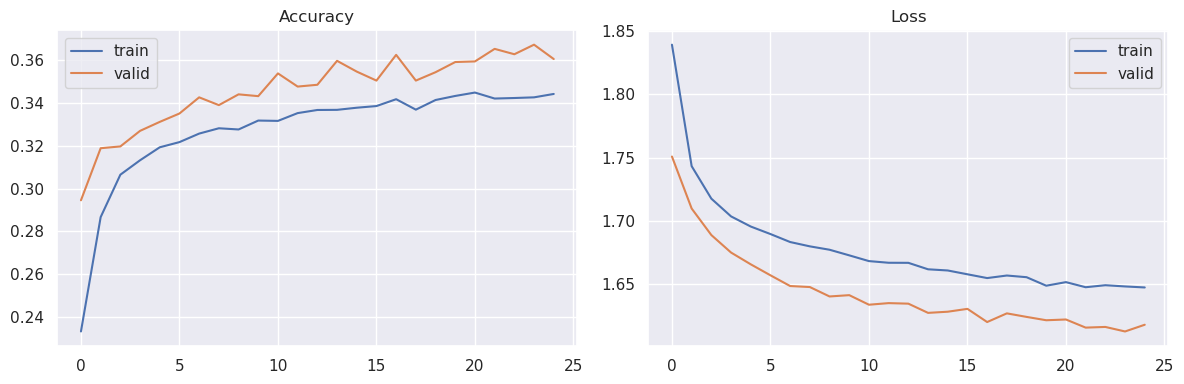

In [36]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


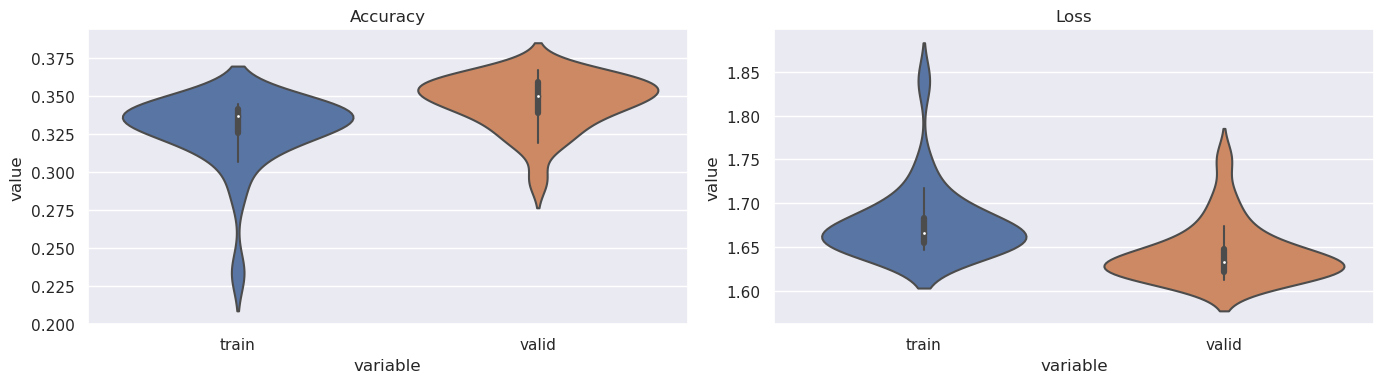

In [37]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 2s 14ms/step
total wrong validation predictions: 2296


              precision    recall  f1-score   support

           0       0.35      0.10      0.15       495
           1       0.00      0.00      0.00        55
           2       0.34      0.12      0.18       512
           3       0.34      0.86      0.49       899
           4       0.37      0.12      0.18       608
           5       0.48      0.53      0.51       400
           6       0.36      0.20      0.25       620

    accuracy                           0.36      3589
   macro avg       0.32      0.28      0.25      3589
weighted avg       0.36      0.36      0.30      3589



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


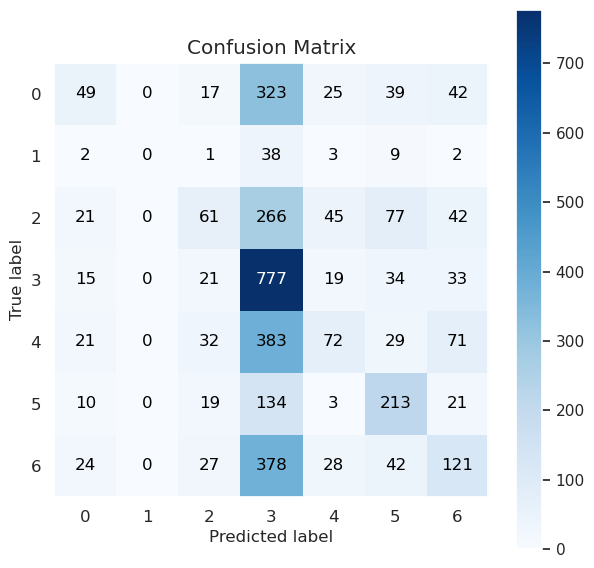

In [38]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

### The confusion matrix indicates that our model is performing well on the "happy" class, but its performance is lacking on the other two classes. A potential explanation for this could be the limited amount of data available for these classes. However, upon reviewing the images, I noticed that certain images from these classes were even challenging for a human to differentiate between "sad" and "neutral." Additionally, facial expressions can vary among individuals, and some people's neutral faces may appear sad.

In [40]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 29ms/step


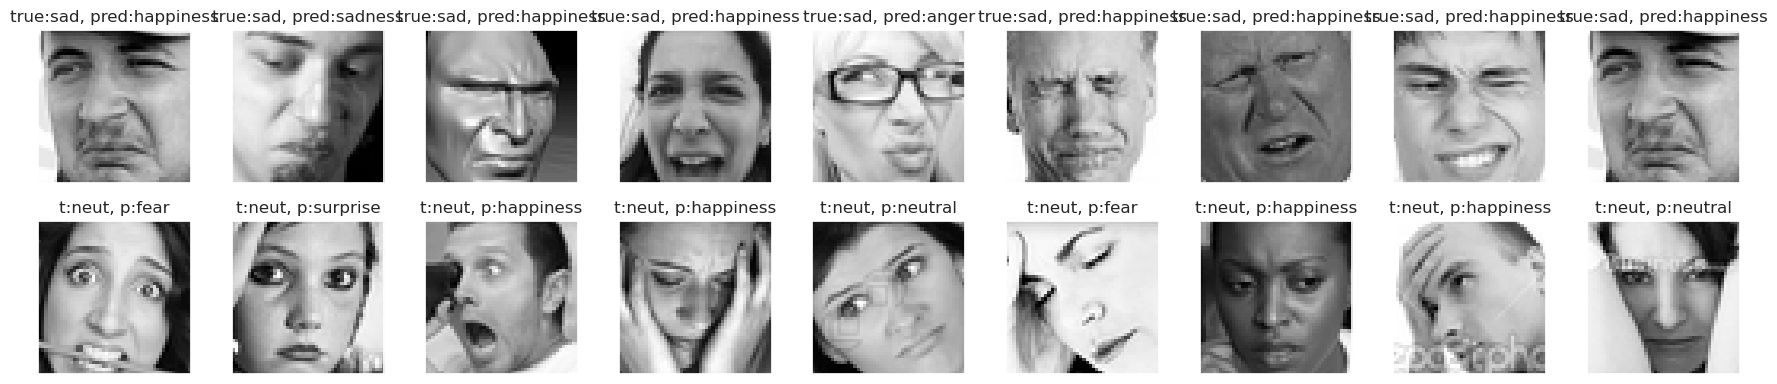

In [42]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()